<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Trabajo de Fin de Master</p>
<p style="margin: 0; text-align:right;">Máster Universitario en Ciencia de Datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicaciones</p>
</div>
</div>
<div style="width: 100%; clear: both;">
<div style="width:100%;">&nbsp;</div>

## Macarena Palomares Pastor
    
# Gentrificación en la ciudad de Málaga

En el presente TFM se cargarán los datos obtenidos para realizar el análisis de gentrificación de la ciudad de Málaga. Para ello se seguirán los siguientes pasos:

<ul>
<li>1. Carga de los CSV de series anuales
<li>2. Unificación de los CSV anteriores en un archivo único
<li>3. Análisis descriptivo de las variables del dataset unificado
<li>4. Limpieza y transformación del dataset
<li>5. Generación de un fichero shapefile con las series anuales completas para cada barrio
<li>6. Gneración de gráficos de radar para análisis de ubicaciones    
<li>7. Aplicación de PCA para la obtención de un índice de gentrificación
<li>8. Aplicación de K-Means
<li>9. Creación de modelos predictivos

</ul>

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Preparación del entorno. Carga de las librerías

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


# 1. Carga de los CSV de series anuales 

Cargamos los CSV con los series anuales de los barrios de la zona urbana de Málaga y comprobamos que su estructura sea la misma para poder unificarlos posteriormente

In [3]:
path_csv = './Datos/Barrios/'
csv_files = [os.path.join(path_csv, '2015.csv'), os.path.join(path_csv, '2016.csv'), os.path.join(path_csv, '2017.csv'),
             os.path.join(path_csv, '2018.csv'), os.path.join(path_csv, '2019.csv'), os.path.join(path_csv, '2020.csv')]

# Variables para almacenar la estructura de columnas y el número de registros
column_structure = []
num_records = []

# Recorrer los años de 2015 a 2020
for csv in csv_files:
        
    # Leer el archivo CSV en un DataFrame
    df = pd.read_csv(csv, encoding='latin-1')
    
    # Obtener la estructura de columnas del DataFrame
    column_structure.append(list(df.columns))
   
    # Obtener el número de registros del DataFrame
    num_records.append(len(df))   
    
# Comprobar si la estructura de columnas y el número de registros son los mismos en todos los archivos
if all(x == column_structure[0] for x in column_structure) and all(x == num_records[0] for x in num_records):
    print("La estructura de columnas y el número de registros son los mismos en todos los archivos CSV.")
    print("Columnas: ", list(df.columns))
    print("Nº de registros: ", len(df))
else:
    print("La estructura de columnas y/o el número de registros son diferentes en los archivos CSV.")


La estructura de columnas y el número de registros son los mismos en todos los archivos CSV.
Columnas:  ['ANUALIDAD', 'NUMBARRIO', 'NOMBARRIO', 'I_ALQUILER', 'HABITANTES', 'EXTRANJEROS', 'SUPERFICIE', 'DENSIDAD', 'MEN_16', 'DE_16_A_65', 'MAY_65', 'TDEP_INF', 'TDEP_MAY', 'TDEP_TOTAL', 'ALTAS_UNIVERSITARIAS', 'BAJAS_SE', 'NACIMIENTOS', 'RENTA_NMPP', 'RESTAURACION', 'COMERCIAL', 'NUM_VIVIENDAS', 'PLAZAS_VIVIENDAS', 'NUM_ESTAB_HOTELEROS', 'PLAZAS_ESTAB_HOTELEROS', 'SUP_ZONAS_VERDES', 'ZV_X_HABITANTES', 'S_SALUD', 'PROX_S_SALUD', 'C_CULTURALES', 'C_OCIO', 'C_DEPORTIVOS', 'C_ALIMENTACION', 'PERSONAS_X_HOGAR']
Nº de registros:  403


# 2. Unificación de los CSV anteriores en un archivo único

Una vez comprobados que tanto la estructura de los CSV como el número de registros es el mismo, unificamos los CSV en un único dataframe y mostramos su definición.

In [4]:
# Dataframe para unificar los CSV cargados
all_data = pd.DataFrame()

for file in csv_files:
    data = pd.read_csv(file, encoding='latin-1')
    all_data = pd.concat([all_data, data])
    
all_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2418 entries, 0 to 402
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ANUALIDAD               2418 non-null   int64  
 1   NUMBARRIO               2418 non-null   int64  
 2   NOMBARRIO               2418 non-null   object 
 3   I_ALQUILER              2418 non-null   float64
 4   HABITANTES              2418 non-null   int64  
 5   EXTRANJEROS             2418 non-null   int64  
 6   SUPERFICIE              2418 non-null   float64
 7   DENSIDAD                2418 non-null   float64
 8   MEN_16                  2418 non-null   int64  
 9   DE_16_A_65              2418 non-null   int64  
 10  MAY_65                  2418 non-null   int64  
 11  TDEP_INF                2418 non-null   float64
 12  TDEP_MAY                2418 non-null   float64
 13  TDEP_TOTAL              2418 non-null   float64
 14  ALTAS_UNIVERSITARIAS    2418 non-null   int64 

# 3. Análisis descriptivo de las variables del dataset unificado

Pasamos a hacer un análisis descriptivo del dataset.
El dataset unificado está compuesto por 303 registros de 6 anualidades con 33 variables, lo que hacen que tenga un total de 2418 registros.
Comenzamos realizando un breve análisis descriptivo de las variables:

In [5]:
# Análisis descriptivo de todas las variables
columnas_descriptivas = all_data.drop(["ANUALIDAD", "NUMBARRIO", "SUPERFICIE"], axis=1).columns
descripcion = all_data[columnas_descriptivas].describe()
print(descripcion)

        I_ALQUILER    HABITANTES  EXTRANJEROS     DENSIDAD      MEN_16  \
count  2418.000000   2418.000000  2418.000000  2418.000000  2418.00000   
mean      3.851795   1409.623656   113.522333   119.251988   235.30976   
std       2.981238   1940.161332   229.310080   149.460276   324.42440   
min       0.000000      0.000000     0.000000     0.000000     0.00000   
25%       0.000000     88.000000     4.000000     8.637174    14.00000   
50%       4.510000    739.000000    30.000000    64.717105   124.50000   
75%       6.120000   1885.000000   120.000000   172.782500   327.00000   
max      15.480000  17875.000000  3035.000000   942.900000  2506.00000   

         DE_16_A_65       MAY_65     TDEP_INF     TDEP_MAY   TDEP_TOTAL  ...  \
count   2418.000000  2418.000000  2418.000000  2418.000000  2418.000000  ...   
mean     933.853184   237.946237    21.947862    22.050842    43.998703  ...   
std     1276.646070   389.895586    14.203957    19.124164    24.901592  ...   
min       -9.

Comprobamos si existen valores NA en nuestro dataset:

In [6]:
# Obtener campos con valores faltantes
missing_values = all_data.isna().sum()

# Filtrar campos con al menos un valor faltante
fields_with_missing_values = missing_values[missing_values > 0]

# Mostrar campos con valores faltantes
print("Valores faltantes: ", missing_values)
print(fields_with_missing_values)


Valores faltantes:  ANUALIDAD                 0
NUMBARRIO                 0
NOMBARRIO                 0
I_ALQUILER                0
HABITANTES                0
EXTRANJEROS               0
SUPERFICIE                0
DENSIDAD                  0
MEN_16                    0
DE_16_A_65                0
MAY_65                    0
TDEP_INF                  0
TDEP_MAY                  0
TDEP_TOTAL                0
ALTAS_UNIVERSITARIAS      0
BAJAS_SE                  0
NACIMIENTOS               0
RENTA_NMPP                0
RESTAURACION              0
COMERCIAL                 0
NUM_VIVIENDAS             0
PLAZAS_VIVIENDAS          0
NUM_ESTAB_HOTELEROS       0
PLAZAS_ESTAB_HOTELEROS    0
SUP_ZONAS_VERDES          0
ZV_X_HABITANTES           0
S_SALUD                   0
PROX_S_SALUD              0
C_CULTURALES              0
C_OCIO                    0
C_DEPORTIVOS              0
C_ALIMENTACION            0
PERSONAS_X_HOGAR          0
dtype: int64
Series([], dtype: int64)


Tras el análisis descriptivo de las variables, encontramos datos que parecen ser erróneos en la variables de PERSONAS_X_HOGAR, donde encontramos que el valor mínimo es de -12 y el valor máximo de 50. Esto puede ser producido porque ese datos se calcula como el número de personas por hojas de padrón. Examinamos los outliers de esa variable:

In [7]:
# Lista de columnas numéricas sin las columnas "ANUALIDAD" y "NUMBARRIO"
columnas_numericas =["PERSONAS_X_HOGAR"]

# Analizar los outliers para cada variable
for columna in columnas_numericas:
    # Calcular los límites para los outliers
    q1 = all_data[columna].quantile(0.25)
    q3 = all_data[columna].quantile(0.75)
    iqr = q3 - q1
    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr

    # Detectar los outliers
    outliers = all_data[(all_data[columna] < limite_inferior) | (all_data[columna] > limite_superior)]
    print(f"Outliers en {columna}:")
    for index, row in outliers.iterrows():
        num_barrio = row["NUMBARRIO"]
        nombre_barrio = row["NOMBARRIO"]
        valor =row[columna]
        print(f"Barrio {num_barrio} - {nombre_barrio}: {valor}")
    print("\n")




Outliers en PERSONAS_X_HOGAR:
Barrio 8 - CAMINO DE OLIAS: 0.0
Barrio 19 - EL DRAGO: 5.6649
Barrio 33 - LA VIÑA: 8.3049
Barrio 37 - PARQUE DEL MORLACO: 0.0
Barrio 42 - LAS NIÑAS: 0.0
Barrio 47 - CASTILLO SANTA CATALINA: 0.0
Barrio 49 - EL LIMONAR: 4.0774
Barrio 56 - CAÑADA DE LOS INGLESES: 4.9886
Barrio 62 - MONTE DE GIBRALFARO: 0.0
Barrio 63 - CAMPOS ELISEOS: 5.6487
Barrio 71 - PUERTO: 0.0
Barrio 82 - SIERRA BLANQUILLA: 5.7203
Barrio 87 - HERRERA ORIA: 6.81
Barrio 94 - SAGRADA FAMILIA: 4.0892
Barrio 96 - HACIENDA LOS MONTES: 4.0186
Barrio 101 - FINCA SAN JOSE: 23.6
Barrio 102 - FINCA LA CONCEPCION: 0.0
Barrio 115 - MIRAFLORES DE LOS ANGELES: 4.7691
Barrio 130 - CAMINO DE ANTEQUERA: 4.3679
Barrio 131 - PORTADA ALTA: 6.8763
Barrio 142 - R.E.N.F.E.: 0.6604
Barrio 144 - NTRA SRA DEL CARMEN: 7.7413
Barrio 146 - POL IND RONDA EXTERIOR: 9.5
Barrio 149 - CEMENTERIO SAN RAFAEL: 0.0
Barrio 153 - PERCHEL SUR: 4.2444
Barrio 162 - 25 AÑOS DE PAZ: 4.5176
Barrio 163 - REGIO: 5.6273
Barrio 165 - GIRON

Tras comprobar los distintos valores de los outliers, concluimos que lo mejor es eliminar esta variable de nuestro análisis posterior.

Comprobamos si hay barrios sin habitantes, que es muy posible porque en la zona urbana de Málaga hay barrios que son meramente industriales, otros por ejemplo están compuesto en su totalidad porque un parque forestal urbano:

In [8]:
# Filtrar los barrios con 0 habitantes por anualidad
barrios_con_0_habitantes = all_data[all_data['HABITANTES'] == 0][['ANUALIDAD', 'NUMBARRIO']]

# Obtener el número de barrios con 0 habitantes por anualidad
num_barrios_con_0_habitantes = barrios_con_0_habitantes.groupby('ANUALIDAD').size()

print(num_barrios_con_0_habitantes)


ANUALIDAD
2015    44
2016    46
2017    45
2018    41
2019    45
2020    46
dtype: int64


Las variables que parecen que pueden aportar algo en nuestro análisis posterior son:
I_ALQUILER, EXTRANJEROS, TDEP_INF, TDEP_MAY, ALTAS_UNIVERSITARIAS, BAJAS_SE, NACIMIENTOS, RENTA_NMPP, RESTAURACION, COMERCIAL, PLAZAS_VIVIENDAS, PLAZAS_ESTAB_HOTELEROS, C_CULTURALES, C_ALIMENTACION, C_OCIO, PERSONAS_X_HOGAR

Generamos la matriz de correlaciones:

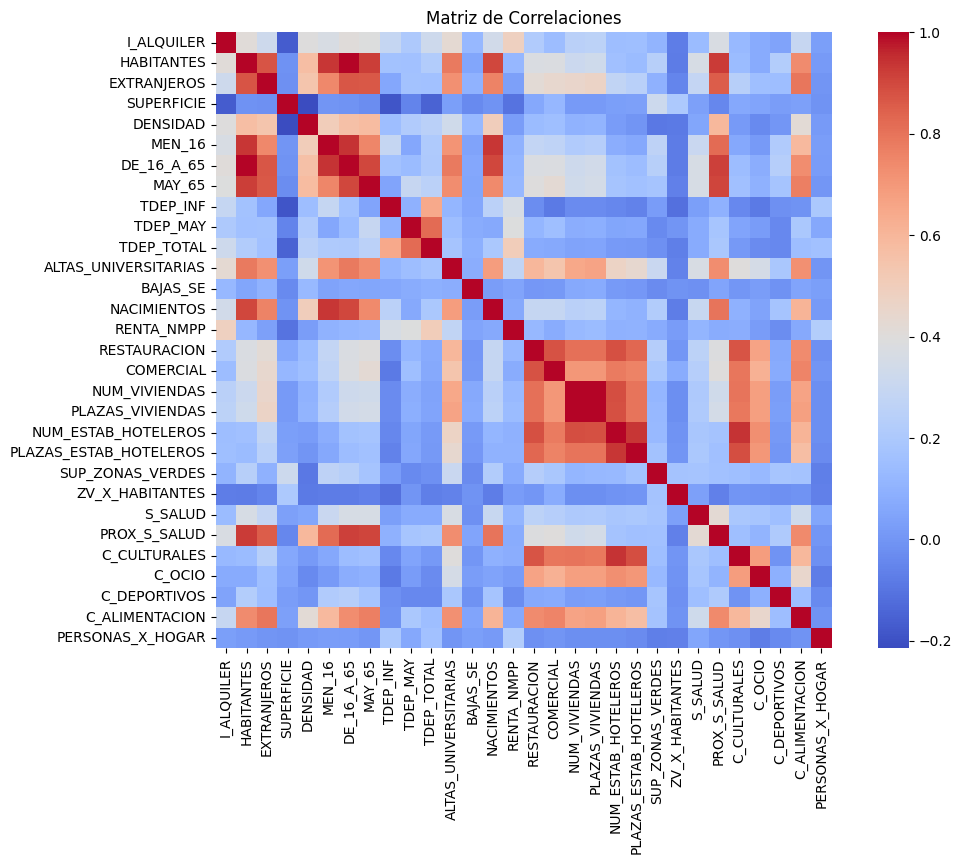

In [9]:
# Calcular la matriz de correlaciones
correlation_matrix = pd.DataFrame(all_data, columns=all_data.columns[3:]).corr()

# Visualizar la matriz de correlaciones
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True)
plt.title('Matriz de Correlaciones')
plt.show()


# 4. Limpieza y transformación del dataset

Procedemos a eliminar de nuestro dataset (de todas las series anuales) aquellos barrios que tienen 10 o menos habitantes en él, al no considerarse barrios habitados relevantes para el estudio y que pueden llevar a obtener conclusiones erróneas.

In [10]:
# Identificar los barrios que tienen 10 o menos habitantes en el año 2020
barrios_eliminar = all_data.loc[(all_data['ANUALIDAD'] == 2020) & (all_data['HABITANTES'] <= 10), 'NOMBARRIO'].unique()

# Eliminar los barrios del dataset de origen
filtered_data = all_data[~all_data['NOMBARRIO'].isin(barrios_eliminar)]

# Mostrar el nombre de los barrios eliminados
print("Barrios eliminados:")
for barrio in barrios_eliminar:
    print(barrio)

print("Total de barrios eliminados:", len(barrios_eliminar))


Barrios eliminados:
FABRICA CEMENTO
CAMINO DE OLIAS
PARQUE DEL MORLACO
LAS NIÑAS
CASTILLO SANTA CATALINA
MONTE DE GIBRALFARO
PUERTO
FINCA LA CONCEPCION
CEMENTERIO SAN RAFAEL
PARQ EMP SANTA BARBARA
POL IND GUADALJAIRE
POL IND CARRANZA
POL COM VALDICIO
TORRE DEL RIO
PALACIO DEPORTES
PARQ EMP ALAMEDA
PARQ EMP SAN LUIS
PARQ EMP LA ESTRELLA
PARQ EMP PEREZ TEXEIRA
LA ESTACION
PARQ EMP GUADALHORCE
PARQ EMP SANTA TERESA
POL IND EL TARAJAL
PARQ EMP LA HUERTECILLA
MERCAMALAGA
AMONIACO
CIUDAD UNIVERSITARIA
POL IND HAZA DE LA CRUZ
LA AZUCARERA
MINERVA
BUTANO
PARQUE DEL GUADALHORCE
HACIENDA CAPITAN
TEJAR DE SALYT
PARQUE TECNOLOGICO
MIRANDA
CAMPO DE GOLF
CAMPAMENTO BENITEZ
POL IND EL ALAMO
CEMENTERIO CHURRIANA
PARQ EMP VILLA ROSA
ARRAIJANAL
PARQ EMP AEROPUERTO
MAKRO
CORTIJO SAN JULIAN
EL LAGARILLO
PARQUE LAS VIRREINAS
LOS CHOCHALES
DEPURADORA GUADALHORCE
HACIENDA SANCHEZ BLANCA
MALAGA 2000
CENTRO DE OCIO
POL IND ORDOÑEZ
COMERCIAL VILLAROSA
LA PLATERA
LAS ERIZAS
SUP-T.8 UNIVERSIDAD
CARAMBUCO
POL IND 

Con lo que nuestro dataset final pasaría a tener un total de 235 barrios.

Procedemos a eliminar las variables que consideramos reduntantes dejando las más significativas. Estas variables a eliminar son: 
- MEN_16, DE_16_A_65, MAY_65, TDEP_TOTAL: las tres primeras se usan para calcular las tasas de dependencia infantil y de mayores, mientras que la última de obtiene como la suma de las anteriores.
- PLAZAS_VIVIENDAS y PLAZAS_ESTAB_HOTELEROS: consideramos más significativos el número de establecimientos que el número de plazas, para obtener los barrios con mas localizaciones
- SUP_ZONAS_VERDES: consideramos más relevante saber el número de metros cuadrados de zona verde por habitante que la superficie total de las mismas
- PROX_S_SALUD: el número consideramos más relevante incluir el número de servicios de salud para poder añadirlo a las locaclizaciones de interés del barrio que el porcentaje de población del barrio que se encuentra próxima a un servicio de salud (a 500 m de un entro de salud o 1000 m de un hospital)

In [11]:
campos_redundantes = ['MEN_16', 'DE_16_A_65', 'MAY_65', 'TDEP_TOTAL', 'PLAZAS_VIVIENDAS',
                      'PLAZAS_ESTAB_HOTELEROS', 'SUP_ZONAS_VERDES', 'PROX_S_SALUD']

filtered_data = filtered_data.drop(columns=campos_redundantes)


Una vez eliminados los campos redundantes, pasamos a transformar los valores de los siguientes campos:
- EXTRANJEROS: inicialmente contiene el número de extranjeros que hay en cada barrio, siendo más interesante relativizarlo con respecto a la población del barrio
- NACIMIENTOS: al igual que en los casos anteriores, es más interesante contar con la tasa de natalidad cada 1.000 habitantes que con el número absoluto de nacimientos
- LOCALIZACIONES: se suman las localizaciones de elementos relevantes el barrio ( resturacion, comercial, viviendas_turísticas, establecimientos hoteleros, servicio de salud, centros culturales, centros de ocio, centros deportivos y centros de alimentación)

In [12]:
filtered_data['EXTRANJEROS'] = filtered_data['EXTRANJEROS'] / filtered_data['HABITANTES'] * 100
filtered_data['NACIMIENTOS'] = filtered_data['NACIMIENTOS'] / filtered_data['HABITANTES'] * 1000
filtered_data['LOCALIZACIONES'] = filtered_data['RESTAURACION'] + filtered_data['COMERCIAL'] + filtered_data['NUM_VIVIENDAS'] + filtered_data['NUM_ESTAB_HOTELEROS'] + filtered_data['S_SALUD'] + filtered_data['C_CULTURALES'] + filtered_data['C_DEPORTIVOS'] + filtered_data['C_OCIO'] + filtered_data['C_ALIMENTACION']


Mostramos el dataset final:

In [13]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2010 entries, 0 to 402
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ANUALIDAD             2010 non-null   int64  
 1   NUMBARRIO             2010 non-null   int64  
 2   NOMBARRIO             2010 non-null   object 
 3   I_ALQUILER            2010 non-null   float64
 4   HABITANTES            2010 non-null   int64  
 5   EXTRANJEROS           2010 non-null   float64
 6   SUPERFICIE            2010 non-null   float64
 7   DENSIDAD              2010 non-null   float64
 8   TDEP_INF              2010 non-null   float64
 9   TDEP_MAY              2010 non-null   float64
 10  ALTAS_UNIVERSITARIAS  2010 non-null   int64  
 11  BAJAS_SE              2010 non-null   int64  
 12  NACIMIENTOS           2010 non-null   float64
 13  RENTA_NMPP            2010 non-null   float64
 14  RESTAURACION          2010 non-null   int64  
 15  COMERCIAL             2010 

# 5. Generación de un fichero shapefile con las series anuales completas para cada barrio

Partiendo del shapefile con la delimitiación de los barrios de la zona urbana de Málaga, que contiene además el NUMBARRIO (identificador único para cada barrio) y su nombre, y el dataset obtenido en el paso anterior, generamos un nuevo shapefile que contendrá un registro para cada barrio y para cada serie anual con la información del dataset anterior.
Este nuevo archivo será el que utilizaremos en la generación de los mapas de análisis de las variables más representativas.

In [14]:
shapefile_path = './Datos/Base/barrios_ZU.shp'

# Cargar el shapefile de los barrios en un GeoDataFrame
barrios_shapefile = gpd.read_file('./Datos/Base/barrios_ZU.shp')

# Crear una lista para almacenar los GeoDataFrames por año
all_years_data = []

# Iterar sobre los años (de 2015 a 2020)
for year in range(2015, 2021):
    # Filtrar los datos del DataFrame por el año actual
    year_data = filtered_data[filtered_data['ANUALIDAD'] == year]

    # Combinar los datos con el shapefile de los barrios usando la columna "NUMBARRIO"
    year_barrios_data = barrios_shapefile.merge(year_data, on='NUMBARRIO', how='right')

    # Agregar el GeoDataFrame del año actual a la lista
    all_years_data.append(year_barrios_data)

# Combinar todos los GeoDataFrames en uno solo
final_shapefile = pd.concat(all_years_data)

# Guardar el shapefile final en un archivo
final_shapefile.to_file('./Datos/Finales/barrios_total.shp', driver='ESRI Shapefile')


# 6. Generación de gráficos de radar para análisis de ubicaciones

Generamos gráficos de radar para cada barrio con los datos del año 2020 para su posterior análisis.

In [15]:
# Obtener los campos deseados
campos_deseados = ['C_ALIMENTACION', 'C_DEPORTIVOS', 'C_OCIO', 'C_CULTURALES', 'S_SALUD', 'RESTAURACION', 'COMERCIAL', 'NUM_VIVIENDAS', 'NUM_ESTAB_HOTELEROS']

# Crear el directorio "Graficos" si no existe
directorio_graficos = 'Graficos'
if not os.path.exists(directorio_graficos):
    os.makedirs(directorio_graficos)

# Escalar los datos del barrio y los datos globales (medias)
scaler = MinMaxScaler()
df_scaled_barrio = pd.DataFrame(scaler.fit_transform(filtered_data[campos_deseados]), columns=campos_deseados)
df_scaled_globales = pd.DataFrame(scaler.transform(filtered_data[campos_deseados].mean().values.reshape(1, -1)), columns=campos_deseados)

idx = 0
# Iterar sobre cada barrio
for id, barrio in filtered_data.iterrows():
    nombre_barrio = barrio['NOMBARRIO']
    valores_barrio = df_scaled_barrio.loc[idx]
    idx = idx + 1

    # Crear DataFrame para el gráfico de radar
    df_grafico = pd.DataFrame({
        'Variable': campos_deseados + campos_deseados,
        'Valor': valores_barrio.tolist() + df_scaled_globales.values.flatten().tolist(),
        'Tipo': ['Barrio'] * len(campos_deseados) + ['Total'] * len(campos_deseados)
    })

    # Crear gráfico de radar
    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(
        r=df_grafico[df_grafico['Tipo'] == 'Barrio']['Valor'],
        theta=df_grafico[df_grafico['Tipo'] == 'Barrio']['Variable'],
        fill='toself',
        name='Barrio'
    ))

    fig.add_trace(go.Scatterpolar(
        r=df_grafico[df_grafico['Tipo'] == 'Total']['Valor'],
        theta=df_grafico[df_grafico['Tipo'] == 'Total']['Variable'],
        fill='toself',
        name='Total'
    ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(visible=True),
        ),
        title=nombre_barrio
    )

    # Guardar la imagen con el nombre del barrio en el directorio "graficos"
    ruta_grafico = os.path.join(directorio_graficos, f'{nombre_barrio}.jpg')
    fig.write_image(ruta_grafico, format='jpg')



# 7. Aplicación de PCA para la obtención de un índice de gentrificación

A continuación aplicamos análisis de componenetes para generar un Índice de Gentrificación, que almacenaremos en un shpaefile para poderlo representar gráficamente en un mapa.

En primer lugar, creamos un dataset con los barrios y la diferencia de las variables entre los años 2020 y 2015 y añadimos además el valor final de la variable porque consideramos que el  indicador  final  debe  reflejar  tanto  las  transformaciones que se han experimentado a lo largo de los años  como  la  intensidad  con  la  que  se  experimenta cada  dimensión  específica.

In [16]:
variables_representativas = ['I_ALQUILER', 'EXTRANJEROS', 'TDEP_INF', 'TDEP_MAY', 'ALTAS_UNIVERSITARIAS', 'BAJAS_SE', 'NACIMIENTOS', 'RENTA_NMPP', 'LOCALIZACIONES']

# Filtrar los datos de 2015 y 2020
data_2015 = filtered_data[filtered_data['ANUALIDAD'] == 2015]
data_2020 = filtered_data[filtered_data['ANUALIDAD'] == 2020]

# Unir los datos de 2015 y 2020 por el número y nombre del barrio
data_merged = data_2015.merge(data_2020, on=['NUMBARRIO', 'NOMBARRIO'], suffixes=('_2015', '_2020'))

# Calcular la diferencia porcentual para cada variable y obtener el valor de 2020
variables = variables_representativas #filtered_data.columns[3:]  # Excluir las primeras tres columnas (ANUALIDAD, NUMBARRIO, NOMBARRIO)
for variable in variables:
    diff = ((data_merged[variable + '_2020'] - data_merged[variable + '_2015'])) 
    data_merged[f'{variable}_diff'] = diff
    data_merged[f'{variable}_final'] = data_merged[variable + '_2020']

# Crear el nuevo dataset con la diferencia porcentual y el valor de 2020
new_dataset = data_merged[['NUMBARRIO', 'NOMBARRIO'] + [f'{variable}_diff' for variable in variables] + [f'{variable}_final' for variable in variables]]

# Mostrar el nuevo dataset
print(new_dataset.head())


   NUMBARRIO       NOMBARRIO  I_ALQUILER_diff  EXTRANJEROS_diff  \
0          1        LA ARAÑA             1.30         -4.444888   
1          3        JARAZMIN             0.67          0.300934   
2          4      EL CANDADO             1.81         -0.269865   
3          5  PLAYA VIRGINIA             1.96         -2.312152   
4          6    EL CHANQUETE             0.00         -2.702037   

   TDEP_INF_diff  TDEP_MAY_diff  ALTAS_UNIVERSITARIAS_diff  BAJAS_SE_diff  \
0       2.914349       2.847608                          2              6   
1      -2.150189      -0.550105                          4             12   
2      -3.056158      12.098018                         -2             12   
3       1.047828      13.114143                          3              6   
4       3.186275      14.460784                          0              6   

   NACIMIENTOS_diff  RENTA_NMPP_diff  LOCALIZACIONES_diff  I_ALQUILER_final  \
0         -4.707722           1658.0                   

Una vez tenemos construido nuestro dataset normalizamos y escalamos los datos y mostramos la matriz de correlaciones:

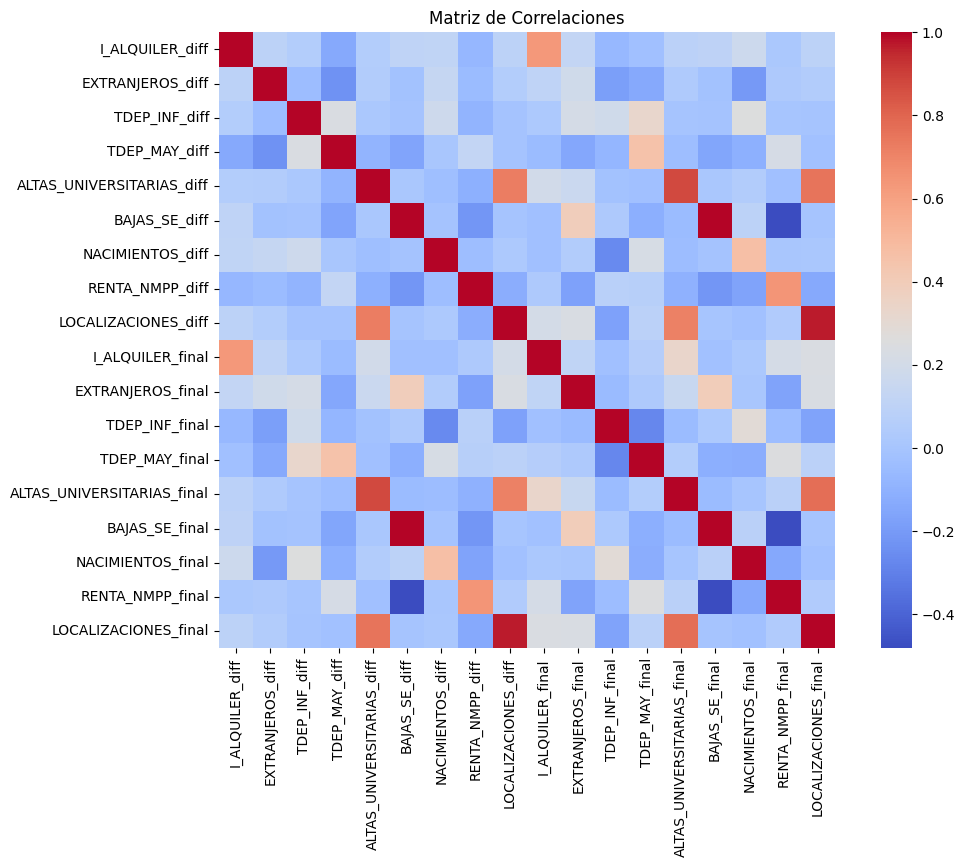

In [17]:
# Normalizar y escalar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(new_dataset.iloc[:, 2:])  # Excluir las dos primeras columnas (NUMBARRIO y NOMBARRIO)

# Calcular la matriz de correlaciones
correlation_matrix = pd.DataFrame(scaled_data, columns=new_dataset.columns[2:]).corr()

# Visualizar la matriz de correlaciones
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True)
plt.title('Matriz de Correlaciones')
plt.show()


Aplicamos PCA:

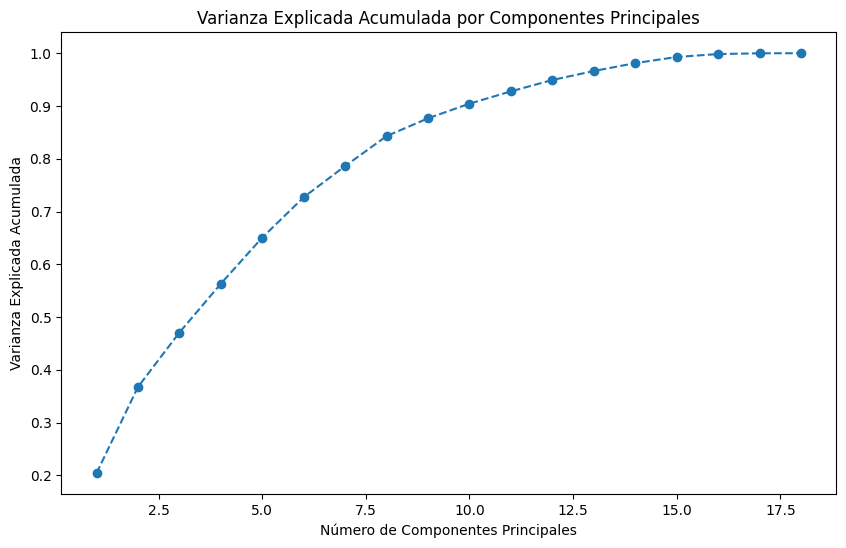

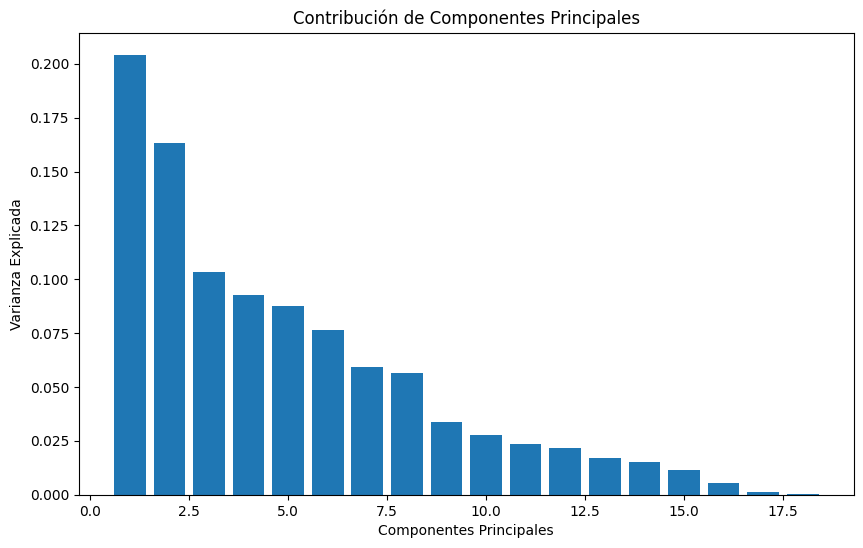

In [18]:
# Aplicar PCA
pca = PCA()
pca.fit(scaled_data)

# Obtener los componentes principales
components = pca.transform(scaled_data)

# Obtener la varianza explicada acumulada
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

# Graficar la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada por Componentes Principales')
plt.show()

# Graficar la contribución de cada componente principal
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.title('Contribución de Componentes Principales')
plt.show()


Generamos nuestro shapefile con el índice de gentrificación resultante:

In [19]:
# Obtener el índice de gentrificación
gentrification_index = pd.DataFrame()
gentrification_index['NUMBARRIO'] = data_merged['NUMBARRIO']
gentrification_index['NOMBARRIO'] = data_merged['NOMBARRIO']
gentrification_index['indice_gentrificacion'] = components[:, 0]  # Usar el primer componente principal como índice de gentrificación

# Obtener el índice de gentrificación como valor absoluto
gentrification_index['indice_gentrificacion'] = abs(components[:, 0])  # Usar el primer componente principal como índice de gentrificación y obtener su valor absoluto

# Normalizar el índice de gentrificación entre 0 y 1
gentrification_index['indice_gentrificacion'] = (gentrification_index['indice_gentrificacion'] - gentrification_index['indice_gentrificacion'].min()) / (gentrification_index['indice_gentrificacion'].max() - gentrification_index['indice_gentrificacion'].min())

# Cargar el shapefile de barrios
shapefile_barrios = gpd.read_file('./Datos/Base/barrios_ZU.shp')

# Unir el índice de gentrificación con el shapefile de barrios
merged_shapefile = shapefile_barrios.merge(gentrification_index, on='NUMBARRIO')

# Guardar el shapefile resultante
merged_shapefile.to_file('./Datos/Finales/indice_gentrificacion.shp', driver='ESRI Shapefile')


# 8. Aplicación de K-Means

A continuación aplicamos K-Means a nuestro conjunto de datos. 
Para ello utilizaremos el dataset con las diferencias de las variables entre el último año (2020) y el primero (2015) de aquellas variables que consideramos significativas:

In [20]:
variables_representativas = ['I_ALQUILER', 'EXTRANJEROS', 'TDEP_INF', 'TDEP_MAY', 'ALTAS_UNIVERSITARIAS', 'BAJAS_SE', 'NACIMIENTOS', 'RENTA_NMPP', 'LOCALIZACIONES']

# Filtrar los datos de 2015 y 2020
data_2015 = filtered_data[filtered_data['ANUALIDAD'] == 2015]
data_2020 = filtered_data[filtered_data['ANUALIDAD'] == 2020]

# Unir los datos de 2015 y 2020 por el número y nombre del barrio
data_merged = data_2015.merge(data_2020, on=['NUMBARRIO', 'NOMBARRIO'], suffixes=('_2015', '_2020'))

# Calcular la diferencia porcentual para cada variable y obtener el valor de 2020
variables = variables_representativas #filtered_data.columns[3:]  # Excluir las primeras tres columnas (ANUALIDAD, NUMBARRIO, NOMBARRIO)
for variable in variables:
    diff = ((data_merged[variable + '_2020'] - data_merged[variable + '_2015'])) 
    data_merged[f'{variable}_diff'] = diff
    data_merged[f'{variable}_final'] = data_merged[variable + '_2020']

# Crear el nuevo dataset con la diferencia porcentual y el valor de 2020
new_dataset = data_merged[['NUMBARRIO', 'NOMBARRIO'] + [f'{variable}_diff' for variable in variables] + [f'{variable}_final' for variable in variables]]

variables_analisis = new_dataset.columns[2:]

# Mostrar el nuevo dataset
print(new_dataset.head())

# Crear un shapefile con las diferencias entre el año 2020 y 2015
shapefile_path = './Datos/Base/barrios_ZU.shp'
barrios = gpd.read_file(shapefile_path)

# Realizar la unión entre new_dataset y barrios por el campo NUMBARRIO
barrios = barrios.merge(new_dataset, on='NUMBARRIO', how='right')

# Guardar el nuevo shapefile con los resultados del clustering
output_shapefile = './Datos/Finales/barrios_dif.shp'
barrios.to_file(output_shapefile)

   NUMBARRIO       NOMBARRIO  I_ALQUILER_diff  EXTRANJEROS_diff  \
0          1        LA ARAÑA             1.30         -4.444888   
1          3        JARAZMIN             0.67          0.300934   
2          4      EL CANDADO             1.81         -0.269865   
3          5  PLAYA VIRGINIA             1.96         -2.312152   
4          6    EL CHANQUETE             0.00         -2.702037   

   TDEP_INF_diff  TDEP_MAY_diff  ALTAS_UNIVERSITARIAS_diff  BAJAS_SE_diff  \
0       2.914349       2.847608                          2              6   
1      -2.150189      -0.550105                          4             12   
2      -3.056158      12.098018                         -2             12   
3       1.047828      13.114143                          3              6   
4       3.186275      14.460784                          0              6   

   NACIMIENTOS_diff  RENTA_NMPP_diff  LOCALIZACIONES_diff  I_ALQUILER_final  \
0         -4.707722           1658.0                   

En primer lugar, utilizamos el método de el codo para determinar el número óptimo de clústers:

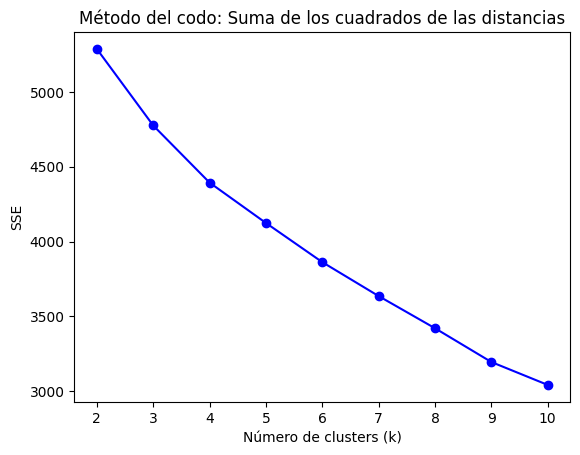

Valor óptimo de k (método de la silueta): 2


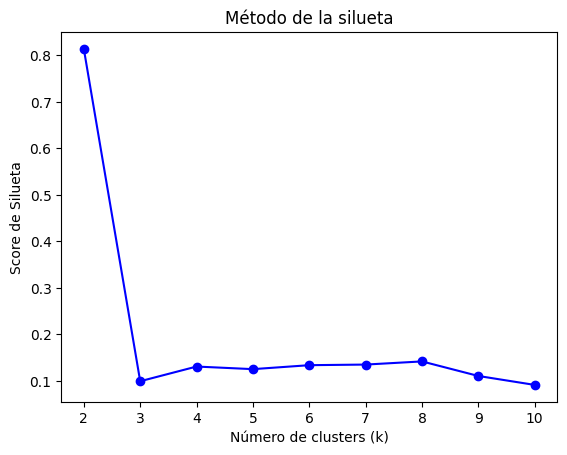

In [21]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(new_dataset[variables_analisis])
df_scaled = pd.DataFrame(df_scaled, columns=variables_analisis)
df_combined = pd.concat([new_dataset[['NUMBARRIO', 'NOMBARRIO']], df_scaled], axis=1)

# Determinar el número óptimo de clusters con el método del codo
X = df_scaled.values
sse = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.plot(k_values, sse, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('SSE')
plt.title('Método del codo: Suma de los cuadrados de las distancias')
plt.show()

# Determinar el número óptimo de clusters usando el método de la silueta
silhouette_scores = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X, labels))

# Encontrar el valor de k con el mayor score de silueta
optimal_k = k_values[np.argmax(silhouette_scores)]
print("Valor óptimo de k (método de la silueta):", optimal_k)

# Graficar el método de la silueta
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Score de Silueta')
plt.title('Método de la silueta')
plt.show()


Comenzamos aplicando el algoritmo de k-means para 3 clústers y posteriormente lo aplicaremos para 4.

In [22]:
# Aplicar el algoritmo k-means
k_optimal = 3

kmeans = KMeans(n_clusters=k_optimal, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_
df_combined['Cluster'] = labels


Guardamos el resultado del k-means en un shapefile para su representación en un mapa.

In [23]:
# Cargar el shapefile de barrios
shapefile_path = './Datos/Base/barrios_ZU.shp'
barrios = gpd.read_file(shapefile_path)

# Realizar la unión entre new_dataset y barrios por el campo NUMBARRIO
barrios = barrios.merge(df_combined, on='NUMBARRIO', how='right')

# Guardar el nuevo shapefile con los resultados del clustering
output_shapefile = './Datos/Finales/kmeans_3.shp'
barrios.to_file(output_shapefile)

Relizamos ahora el mismo proceso pero para 4 clústers:

In [24]:
# Aplicar el algoritmo k-means
k_optimal = 4

kmeans = KMeans(n_clusters=k_optimal, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_
df_combined['Cluster'] = labels

# Cargar el shapefile de barrios
shapefile_path = './Datos/Base/barrios_ZU.shp'
barrios = gpd.read_file(shapefile_path)

# Realizar la unión entre new_dataset y barrios por el campo NUMBARRIO
barrios = barrios.merge(df_combined, on='NUMBARRIO', how='right')

# Guardar el nuevo shapefile con los resultados del clustering
output_shapefile = './Datos/Finales/kmeans_4.shp'
barrios.to_file(output_shapefile)

Relizamos ahora el mismo proceso pero para 6 clústers:

In [25]:
# Aplicar el algoritmo k-means
k_optimal = 6

kmeans = KMeans(n_clusters=k_optimal, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_
df_combined['Cluster'] = labels

# Cargar el shapefile de barrios
shapefile_path = './Datos/Base/barrios_ZU.shp'
barrios = gpd.read_file(shapefile_path)

# Realizar la unión entre new_dataset y barrios por el campo NUMBARRIO
barrios = barrios.merge(df_combined, on='NUMBARRIO', how='right')

# Guardar el nuevo shapefile con los resultados del clustering
output_shapefile = './Datos/Finales/kmeans_6.shp'
barrios.to_file(output_shapefile)

# 9. Creación de modelos predictivos

Comenzamos uniendo los datos del resultado del PCA (dataset gentrification_index) con el dataset "new_dataset" que contiene los datos de diferencias entre 2020 y 2015 y el valor final de cada variable por el campo NUMBARRIO que se encuentra en ambos conjuntos. Creamos un campo "gentrificado" al que se lasignamos valor 1 si el índice de gentrificación parar ese barrio supera el 10%. Comprobamos el número de elementos de cada clase, para el campo gentrificado que hemos creado, para saber si están balanceadas.

   NUMBARRIO     NOMBARRIO_x  indice_gentrificacion     NOMBARRIO_y  \
0          1        LA ARAÑA               0.040513        LA ARAÑA   
1          3        JARAZMIN               0.037388        JARAZMIN   
2          4      EL CANDADO               0.002569      EL CANDADO   
3          5  PLAYA VIRGINIA               0.018289  PLAYA VIRGINIA   
4          6    EL CHANQUETE               0.047862    EL CHANQUETE   

   I_ALQUILER_diff  EXTRANJEROS_diff  TDEP_INF_diff  TDEP_MAY_diff  \
0        -0.068265         -1.353868       0.583831      -0.040899   
1        -0.385466         -0.100434      -0.095750      -0.467037   
2         0.188517         -0.251189      -0.217317       1.119280   
3         0.264042         -0.790584       0.333373       1.246721   
4        -0.722808         -0.893558       0.620319       1.415616   

   ALTAS_UNIVERSITARIAS_diff  BAJAS_SE_diff  ...  LOCALIZACIONES_diff  \
0                  -0.307873      -0.723111  ...            -0.254557   
1     

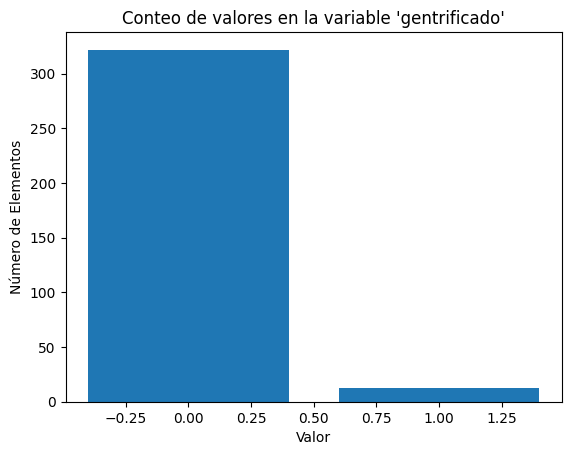

In [26]:
# Unir los datasets por el campo NUMBARRIO
merged_dataset = gentrification_index.merge(df_combined, on="NUMBARRIO")

# Eliminar el campo "Cluster" del dataset
merged_dataset = merged_dataset.drop("Cluster", axis=1)
print(merged_dataset.head())

# Generar el campo "gentrificado" a partir del campo "gentrificacion"
merged_dataset["gentrificado"] = np.where(merged_dataset["indice_gentrificacion"] >= 0.10, 1, 0)

# Separar los datos en características (X) y variable objetivo (y)
X = merged_dataset.drop(["NUMBARRIO", "NOMBARRIO_x", "NOMBARRIO_y", "indice_gentrificacion", "gentrificado"], axis=1)
y = merged_dataset["gentrificado"]

# Contar el número de elementos con valor 0 y valor 1 en la variable "gentrificado"
count = merged_dataset["gentrificado"].value_counts()

# Crear el gráfico de barras
plt.bar(count.index, count.values)

# Etiquetas de los ejes
plt.xlabel("Valor")
plt.ylabel("Número de Elementos")

# Título del gráfico
plt.title("Conteo de valores en la variable 'gentrificado'")

# Mostrar el gráfico
plt.show()


Como se puede ver en el gráfico anterior, las clases están muy desbalanceadas.


Se crea un pipeline donde se aplica SMOTE para eliminar el desbalanceo y se aplica a los 3 modelos:

Pipeline con SMOTE:
--------------------------------------------
Modelo: Regresión Logística
Precisión media: 98.81%
Desviación estándar de la precisión: 0.60%
Accuraccy: 98.51%
Precision: 1.00
Recall: 0.75
F1-score: 0.86
Matriz de confusión:
[[63  0]
 [ 1  3]]
--------------------------------------------
Modelo: Random Forest
Precisión media: 96.72%
Desviación estándar de la precisión: 1.46%
Accuraccy: 97.01%
Precision: 1.00
Recall: 0.50
F1-score: 0.67
Matriz de confusión:
[[63  0]
 [ 2  2]]
--------------------------------------------
Modelo: SVM
Precisión media: 99.10%
Desviación estándar de la precisión: 0.73%
Accuraccy: 98.51%
Precision: 1.00
Recall: 0.75
F1-score: 0.86
Matriz de confusión:
[[63  0]
 [ 1  3]]


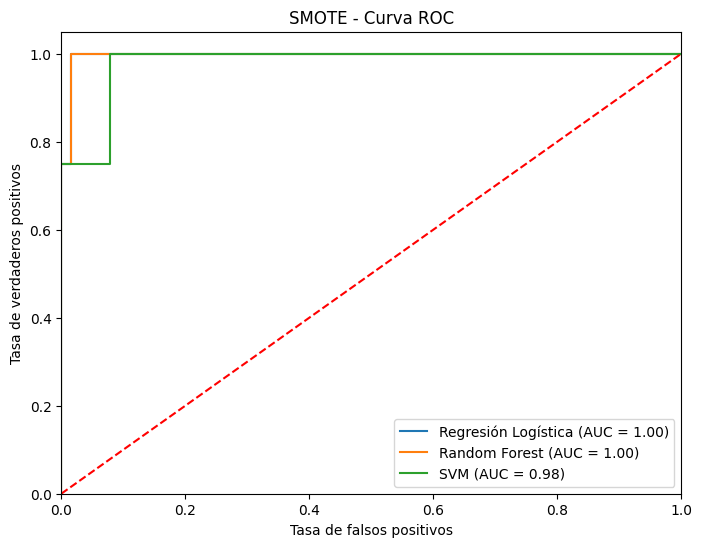

In [27]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear los modelos de regresión logística, random forest y SVM
logistic_model = LogisticRegression()
random_forest_model = RandomForestClassifier()
svm_model = SVC()

# Crear los pipelines con sobremuestreo SMOTE 
logistic_pipeline = make_pipeline(SMOTE(), logistic_model)
random_forest_pipeline = make_pipeline(SMOTE(), random_forest_model)
svm_pipeline = make_pipeline(SMOTE(), svm_model)

# Aplicar validación cruzada y obtener los resultados
logistic_scores = cross_val_score(logistic_pipeline, X, y, cv=5, scoring='accuracy')
random_forest_scores = cross_val_score(random_forest_pipeline, X, y, cv=5, scoring='accuracy')
svm_scores = cross_val_score(svm_pipeline, X, y, cv=5, scoring='accuracy')

# Calcular las métricas promedio y desviación estándar de la precisión
logistic_mean_accuracy = logistic_scores.mean()
logistic_std_accuracy = logistic_scores.std()
random_forest_mean_accuracy = random_forest_scores.mean()
random_forest_std_accuracy = random_forest_scores.std()
svm_mean_accuracy = svm_scores.mean()
svm_std_accuracy = svm_scores.std()

# Entrenar y realizar predicciones con el modelo de regresión logística
logistic_pipeline.fit(X_train, y_train)
logistic_predictions = logistic_pipeline.predict(X_test)

# Entrenar y realizar predicciones con el modelo de random forest
random_forest_pipeline.fit(X_train, y_train)
random_forest_predictions = random_forest_pipeline.predict(X_test)

# Entrenar y realizar predicciones con el modelo de SVM
svm_pipeline.fit(X_train, y_train)
svm_predictions = svm_pipeline.predict(X_test)

# Calcular las métricas para el modelo de regresión logística
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
logistic_precision = precision_score(y_test, logistic_predictions)
logistic_recall = recall_score(y_test, logistic_predictions)
logistic_f1 = f1_score(y_test, logistic_predictions)
logistic_confusion_matrix = confusion_matrix(y_test, logistic_predictions)

# Calcular las métricas para el modelo de random forest
random_forest_accuracy = accuracy_score(y_test, random_forest_predictions)
random_forest_precision = precision_score(y_test, random_forest_predictions)
random_forest_recall = recall_score(y_test, random_forest_predictions)
random_forest_f1 = f1_score(y_test, random_forest_predictions)
random_forest_confusion_matrix = confusion_matrix(y_test, random_forest_predictions)

# Calcular las métricas para el modelo de SVM
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_precision = precision_score(y_test, svm_predictions)
svm_recall = recall_score(y_test, svm_predictions)
svm_f1 = f1_score(y_test, svm_predictions)
svm_confusion_matrix = confusion_matrix(y_test, svm_predictions)

# Imprimir los resultados
print("Pipeline con SMOTE:")
print("--------------------------------------------")
print("Modelo: Regresión Logística")
print("Precisión media: {:.2f}%".format(logistic_mean_accuracy * 100))
print("Desviación estándar de la precisión: {:.2f}%".format(logistic_std_accuracy * 100))
print("Accuraccy: {:.2f}%".format(logistic_accuracy * 100))
print("Precision: {:.2f}".format(logistic_precision))
print("Recall: {:.2f}".format(logistic_recall))
print("F1-score: {:.2f}".format(logistic_f1))
print("Matriz de confusión:")
print(logistic_confusion_matrix)
print("--------------------------------------------")
print("Modelo: Random Forest")
print("Precisión media: {:.2f}%".format(random_forest_mean_accuracy * 100))
print("Desviación estándar de la precisión: {:.2f}%".format(random_forest_std_accuracy * 100))
print("Accuraccy: {:.2f}%".format(random_forest_accuracy * 100))
print("Precision: {:.2f}".format(random_forest_precision))
print("Recall: {:.2f}".format(random_forest_recall))
print("F1-score: {:.2f}".format(random_forest_f1))
print("Matriz de confusión:")
print(random_forest_confusion_matrix)
print("--------------------------------------------")
print("Modelo: SVM")
print("Precisión media: {:.2f}%".format(svm_mean_accuracy * 100))
print("Desviación estándar de la precisión: {:.2f}%".format(svm_std_accuracy * 100))
print("Accuraccy: {:.2f}%".format(svm_accuracy * 100))
print("Precision: {:.2f}".format(svm_precision))
print("Recall: {:.2f}".format(svm_recall))
print("F1-score: {:.2f}".format(svm_f1))
print("Matriz de confusión:")
print(svm_confusion_matrix)


# Crear las curvas ROC
logistic_fpr, logistic_tpr, _ = roc_curve(y_test, logistic_pipeline.predict_proba(X_test)[:, 1])
logistic_auc = roc_auc_score(y_test, logistic_pipeline.predict_proba(X_test)[:, 1])

random_forest_fpr, random_forest_tpr, _ = roc_curve(y_test, random_forest_pipeline.predict_proba(X_test)[:, 1])
random_forest_auc = roc_auc_score(y_test, random_forest_pipeline.predict_proba(X_test)[:, 1])

svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_pipeline.decision_function(X_test))
svm_auc = roc_auc_score(y_test, svm_pipeline.decision_function(X_test))

# Graficar las curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(logistic_fpr, logistic_tpr, label='Regresión Logística (AUC = {:.2f})'.format(logistic_auc))
plt.plot(random_forest_fpr, random_forest_tpr, label='Random Forest (AUC = {:.2f})'.format(random_forest_auc))
plt.plot(svm_fpr, svm_tpr, label='SVM (AUC = {:.2f})'.format(svm_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('SMOTE - Curva ROC')
plt.legend(loc='lower right')
plt.show()

Se aplica RandomUnderSampler a los 3 modelos:

Pipeline con RandomUnderSampler:
--------------------------------------------
Modelo: Regresión Logística
Precisión media: 93.13%
Desviación estándar de la precisión: 8.15%
Accuraccy: 95.52%
Precision: 0.60
Recall: 0.75
F1-score: 0.67
Matriz de confusión:
[[61  2]
 [ 1  3]]
--------------------------------------------
Modelo: Random Forest
Precisión media: 94.93%
Desviación estándar de la precisión: 4.28%
Accuraccy: 94.03%
Precision: 0.50
Recall: 1.00
F1-score: 0.67
Matriz de confusión:
[[59  4]
 [ 0  4]]
--------------------------------------------
Modelo: SVM
Precisión media: 92.24%
Desviación estándar de la precisión: 8.14%
Accuraccy: 89.55%
Precision: 0.36
Recall: 1.00
F1-score: 0.53
Matriz de confusión:
[[56  7]
 [ 0  4]]


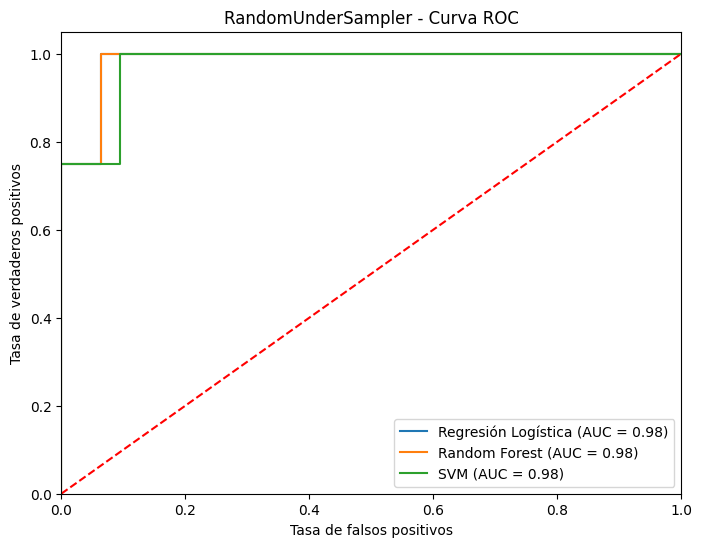

In [28]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear los modelos de regresión logística, random forest y SVM
logistic_model = LogisticRegression()
random_forest_model = RandomForestClassifier()
svm_model = SVC()

# Crear los pipelines con sobremuestreo SMOTE 
logistic_pipeline = make_pipeline(RandomUnderSampler(), logistic_model)
random_forest_pipeline = make_pipeline(RandomUnderSampler(), random_forest_model)
svm_pipeline = make_pipeline(RandomUnderSampler(), svm_model)

# Aplicar validación cruzada y obtener los resultados
logistic_scores = cross_val_score(logistic_pipeline, X, y, cv=5, scoring='accuracy')
random_forest_scores = cross_val_score(random_forest_pipeline, X, y, cv=5, scoring='accuracy')
svm_scores = cross_val_score(svm_pipeline, X, y, cv=5, scoring='accuracy')

# Calcular las métricas promedio y desviación estándar de la precisión
logistic_mean_accuracy = logistic_scores.mean()
logistic_std_accuracy = logistic_scores.std()
random_forest_mean_accuracy = random_forest_scores.mean()
random_forest_std_accuracy = random_forest_scores.std()
svm_mean_accuracy = svm_scores.mean()
svm_std_accuracy = svm_scores.std()

# Entrenar y realizar predicciones con el modelo de regresión logística
logistic_pipeline.fit(X_train, y_train)
logistic_predictions = logistic_pipeline.predict(X_test)

# Entrenar y realizar predicciones con el modelo de random forest
random_forest_pipeline.fit(X_train, y_train)
random_forest_predictions = random_forest_pipeline.predict(X_test)

# Entrenar y realizar predicciones con el modelo de SVM
svm_pipeline.fit(X_train, y_train)
svm_predictions = svm_pipeline.predict(X_test)

# Calcular las métricas para el modelo de regresión logística
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
logistic_precision = precision_score(y_test, logistic_predictions)
logistic_recall = recall_score(y_test, logistic_predictions)
logistic_f1 = f1_score(y_test, logistic_predictions)
logistic_confusion_matrix = confusion_matrix(y_test, logistic_predictions)

# Calcular las métricas para el modelo de random forest
random_forest_accuracy = accuracy_score(y_test, random_forest_predictions)
random_forest_precision = precision_score(y_test, random_forest_predictions)
random_forest_recall = recall_score(y_test, random_forest_predictions)
random_forest_f1 = f1_score(y_test, random_forest_predictions)
random_forest_confusion_matrix = confusion_matrix(y_test, random_forest_predictions)

# Calcular las métricas para el modelo de SVM
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_precision = precision_score(y_test, svm_predictions)
svm_recall = recall_score(y_test, svm_predictions)
svm_f1 = f1_score(y_test, svm_predictions)
svm_confusion_matrix = confusion_matrix(y_test, svm_predictions)

# Imprimir los resultados
print("Pipeline con RandomUnderSampler:")
print("--------------------------------------------")
print("Modelo: Regresión Logística")
print("Precisión media: {:.2f}%".format(logistic_mean_accuracy * 100))
print("Desviación estándar de la precisión: {:.2f}%".format(logistic_std_accuracy * 100))
print("Accuraccy: {:.2f}%".format(logistic_accuracy * 100))
print("Precision: {:.2f}".format(logistic_precision))
print("Recall: {:.2f}".format(logistic_recall))
print("F1-score: {:.2f}".format(logistic_f1))
print("Matriz de confusión:")
print(logistic_confusion_matrix)
print("--------------------------------------------")
print("Modelo: Random Forest")
print("Precisión media: {:.2f}%".format(random_forest_mean_accuracy * 100))
print("Desviación estándar de la precisión: {:.2f}%".format(random_forest_std_accuracy * 100))
print("Accuraccy: {:.2f}%".format(random_forest_accuracy * 100))
print("Precision: {:.2f}".format(random_forest_precision))
print("Recall: {:.2f}".format(random_forest_recall))
print("F1-score: {:.2f}".format(random_forest_f1))
print("Matriz de confusión:")
print(random_forest_confusion_matrix)
print("--------------------------------------------")
print("Modelo: SVM")
print("Precisión media: {:.2f}%".format(svm_mean_accuracy * 100))
print("Desviación estándar de la precisión: {:.2f}%".format(svm_std_accuracy * 100))
print("Accuraccy: {:.2f}%".format(svm_accuracy * 100))
print("Precision: {:.2f}".format(svm_precision))
print("Recall: {:.2f}".format(svm_recall))
print("F1-score: {:.2f}".format(svm_f1))
print("Matriz de confusión:")
print(svm_confusion_matrix)


# Crear las curvas ROC
logistic_fpr, logistic_tpr, _ = roc_curve(y_test, logistic_pipeline.predict_proba(X_test)[:, 1])
logistic_auc = roc_auc_score(y_test, logistic_pipeline.predict_proba(X_test)[:, 1])

random_forest_fpr, random_forest_tpr, _ = roc_curve(y_test, random_forest_pipeline.predict_proba(X_test)[:, 1])
random_forest_auc = roc_auc_score(y_test, random_forest_pipeline.predict_proba(X_test)[:, 1])

svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_pipeline.decision_function(X_test))
svm_auc = roc_auc_score(y_test, svm_pipeline.decision_function(X_test))

# Graficar las curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(logistic_fpr, logistic_tpr, label='Regresión Logística (AUC = {:.2f})'.format(logistic_auc))
plt.plot(random_forest_fpr, random_forest_tpr, label='Random Forest (AUC = {:.2f})'.format(random_forest_auc))
plt.plot(svm_fpr, svm_tpr, label='SVM (AUC = {:.2f})'.format(svm_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('RandomUnderSampler - Curva ROC')
plt.legend(loc='lower right')
plt.show()

Se aplica ADASYN para eliminar el desbalanceo a los 3 modelos:

Pipeline con ADASYN:
--------------------------------------------
Modelo: Regresión Logística
Precisión media: 98.81%
Desviación estándar de la precisión: 0.60%
Accuraccy: 98.51%
Precision: 1.00
Recall: 0.75
F1-score: 0.86
Matriz de confusión:
[[63  0]
 [ 1  3]]
--------------------------------------------
Modelo: Random Forest
Precisión media: 96.72%
Desviación estándar de la precisión: 1.46%
Accuraccy: 95.52%
Precision: 0.67
Recall: 0.50
F1-score: 0.57
Matriz de confusión:
[[62  1]
 [ 2  2]]
--------------------------------------------
Modelo: SVM
Precisión media: 98.51%
Desviación estándar de la precisión: 1.63%
Accuraccy: 97.01%
Precision: 1.00
Recall: 0.50
F1-score: 0.67
Matriz de confusión:
[[63  0]
 [ 2  2]]


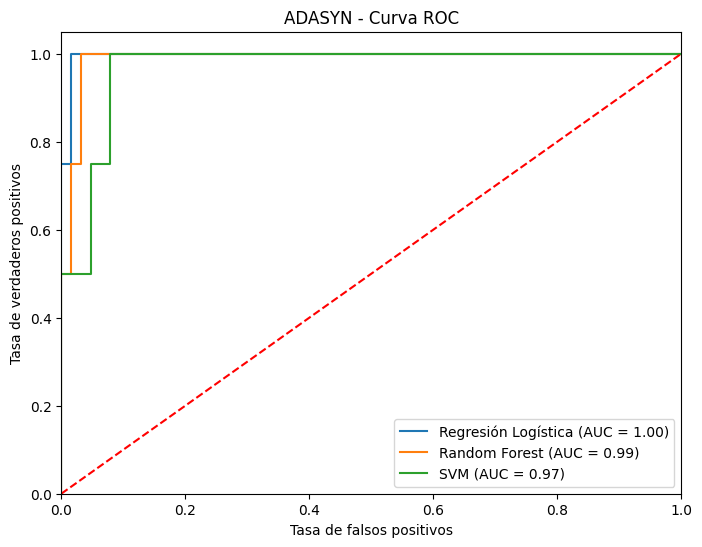

In [29]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear los modelos de regresión logística, random forest y SVM
logistic_model = LogisticRegression()
random_forest_model = RandomForestClassifier()
svm_model = SVC()

# Crear los pipelines con sobremuestreo ADASYN 
logistic_pipeline = make_pipeline(ADASYN(), logistic_model)
random_forest_pipeline = make_pipeline(ADASYN(), random_forest_model)
svm_pipeline = make_pipeline(ADASYN(), svm_model)

# Aplicar validación cruzada y obtener los resultados
logistic_scores = cross_val_score(logistic_pipeline, X, y, cv=5, scoring='accuracy')
random_forest_scores = cross_val_score(random_forest_pipeline, X, y, cv=5, scoring='accuracy')
svm_scores = cross_val_score(svm_pipeline, X, y, cv=5, scoring='accuracy')

# Calcular las métricas promedio y desviación estándar de la precisión
logistic_mean_accuracy = logistic_scores.mean()
logistic_std_accuracy = logistic_scores.std()
random_forest_mean_accuracy = random_forest_scores.mean()
random_forest_std_accuracy = random_forest_scores.std()
svm_mean_accuracy = svm_scores.mean()
svm_std_accuracy = svm_scores.std()

# Entrenar y realizar predicciones con el modelo de regresión logística
logistic_pipeline.fit(X_train, y_train)
logistic_predictions = logistic_pipeline.predict(X_test)

# Entrenar y realizar predicciones con el modelo de random forest
random_forest_pipeline.fit(X_train, y_train)
random_forest_predictions = random_forest_pipeline.predict(X_test)

# Entrenar y realizar predicciones con el modelo de SVM
svm_pipeline.fit(X_train, y_train)
svm_predictions = svm_pipeline.predict(X_test)

# Calcular las métricas para el modelo de regresión logística
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
logistic_precision = precision_score(y_test, logistic_predictions)
logistic_recall = recall_score(y_test, logistic_predictions)
logistic_f1 = f1_score(y_test, logistic_predictions)
logistic_confusion_matrix = confusion_matrix(y_test, logistic_predictions)

# Calcular las métricas para el modelo de random forest
random_forest_accuracy = accuracy_score(y_test, random_forest_predictions)
random_forest_precision = precision_score(y_test, random_forest_predictions)
random_forest_recall = recall_score(y_test, random_forest_predictions)
random_forest_f1 = f1_score(y_test, random_forest_predictions)
random_forest_confusion_matrix = confusion_matrix(y_test, random_forest_predictions)

# Calcular las métricas para el modelo de SVM
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_precision = precision_score(y_test, svm_predictions)
svm_recall = recall_score(y_test, svm_predictions)
svm_f1 = f1_score(y_test, svm_predictions)
svm_confusion_matrix = confusion_matrix(y_test, svm_predictions)

# Imprimir los resultados
print("Pipeline con ADASYN:")
print("--------------------------------------------")
print("Modelo: Regresión Logística")
print("Precisión media: {:.2f}%".format(logistic_mean_accuracy * 100))
print("Desviación estándar de la precisión: {:.2f}%".format(logistic_std_accuracy * 100))
print("Accuraccy: {:.2f}%".format(logistic_accuracy * 100))
print("Precision: {:.2f}".format(logistic_precision))
print("Recall: {:.2f}".format(logistic_recall))
print("F1-score: {:.2f}".format(logistic_f1))
print("Matriz de confusión:")
print(logistic_confusion_matrix)
print("--------------------------------------------")
print("Modelo: Random Forest")
print("Precisión media: {:.2f}%".format(random_forest_mean_accuracy * 100))
print("Desviación estándar de la precisión: {:.2f}%".format(random_forest_std_accuracy * 100))
print("Accuraccy: {:.2f}%".format(random_forest_accuracy * 100))
print("Precision: {:.2f}".format(random_forest_precision))
print("Recall: {:.2f}".format(random_forest_recall))
print("F1-score: {:.2f}".format(random_forest_f1))
print("Matriz de confusión:")
print(random_forest_confusion_matrix)
print("--------------------------------------------")
print("Modelo: SVM")
print("Precisión media: {:.2f}%".format(svm_mean_accuracy * 100))
print("Desviación estándar de la precisión: {:.2f}%".format(svm_std_accuracy * 100))
print("Accuraccy: {:.2f}%".format(svm_accuracy * 100))
print("Precision: {:.2f}".format(svm_precision))
print("Recall: {:.2f}".format(svm_recall))
print("F1-score: {:.2f}".format(svm_f1))
print("Matriz de confusión:")
print(svm_confusion_matrix)


# Crear las curvas ROC
logistic_fpr, logistic_tpr, _ = roc_curve(y_test, logistic_pipeline.predict_proba(X_test)[:, 1])
logistic_auc = roc_auc_score(y_test, logistic_pipeline.predict_proba(X_test)[:, 1])

random_forest_fpr, random_forest_tpr, _ = roc_curve(y_test, random_forest_pipeline.predict_proba(X_test)[:, 1])
random_forest_auc = roc_auc_score(y_test, random_forest_pipeline.predict_proba(X_test)[:, 1])

svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_pipeline.decision_function(X_test))
svm_auc = roc_auc_score(y_test, svm_pipeline.decision_function(X_test))

# Graficar las curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(logistic_fpr, logistic_tpr, label='Regresión Logística (AUC = {:.2f})'.format(logistic_auc))
plt.plot(random_forest_fpr, random_forest_tpr, label='Random Forest (AUC = {:.2f})'.format(random_forest_auc))
plt.plot(svm_fpr, svm_tpr, label='SVM (AUC = {:.2f})'.format(svm_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('ADASYN - Curva ROC')
plt.legend(loc='lower right')
plt.show()
